In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
Vhel = table['Vhel']

N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)

for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
    
    
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22
r_z   = rrr-zzz
g_r   = ggg-rrr
r_z   = rrr-zzz

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invali

In [5]:
####################################
def TFRcurve(logW, slope, zp, A, band):


    if band in ['w1', 'w2']:
        logW0=2.4 
    else:
        logW0=2.5

    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+(zp)
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

def DMcalc(logW, mag, band='i', deltaDM=0, dlogW=None):
    
    dmag = 0.05
    ds=0; dzp=0
    if band=='u':
        dmag = 0.1
        slope=-7.03 ; zp=-19.27; Czp=-0.08; A2=6.59
        ds = 0.17 ; dzp = 0.13
    elif band=='g':
        slope=-7.37 ; zp=-20.15; Czp=-0.11; A2=4.18
        ds = 0.13 ; dzp = 0.11
    elif band=='r':
        slope=-7.96 ; zp=-20.57; Czp=-0.08; A2=4.56   
        ds = 0.13 ; dzp = 0.10
    elif band=='i':
        slope=-8.32 ; zp=-20.80; Czp=-0.04; A2=5.34
        ds = 0.13 ; dzp = 0.10
    elif band=='z':
        slope=-8.46 ; zp=-20.89; Czp=-0.08; A2=5.81 
        ds = 0.13 ; dzp = 0.10
    elif band=='w1':
        slope=-9.47 ; zp=-20.36; Czp=0.0; A2=3.81
        ds = 0.14 ; dzp = 0.07
    elif band=='w2':
        slope=-9.66 ; zp=-19.76; Czp=0.0; A2=4.42
        ds = 0.14 ; dzp = 0.07
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    DM = (mag-MAG) + deltaDM
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
        return DM, dDM
    else:
        return DM
    
###################################  
def DMcalcWc(logW, mag, i_w, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_i_w1 = i_w - (1.18*(logW-2.5)-0.47)
        magCorrection = -1*(-1.08*(D_i_w1)-0.04)
        mag_c = mag + magCorrection
        slope=-9.27 ; zp=-20.29; Czp=0.0; A2=0
        ds = 0.13 ; dzp = 0.10
    elif band=='w2':
        D_i_w2 = i_w - (1.32*(logW-2.5)-1.04)
        magCorrection = -1*(-1.09*(D_i_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.40 ; zp=-19.70; Czp=0.0; A2=0         
        ds = 0.14 ; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  
def DMcalcWmu(logW, mag, mu50, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_mu50_w1 = mu50 - (-4.05*(logW-2.5)+22.63)
        magCorrection = -1*(0.16*(D_mu50_w1)-0.05)
        mag_c = mag + magCorrection
        slope=-9.15 ; zp=-20.26; Czp=0.0; A2=2.55
        ds = 0.13 ; dzp = 0.07
    elif band=='w2':
        D_mu50_w2 = mu50 - (-4.06*(logW-2.5)+23.21)
        magCorrection = -1*(0.19*(D_mu50_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.18 ; zp=-19.62; Czp=0.0; A2=2.67 
        ds = 0.13 ; dzp = 0.07
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  

def DMcalcWm21(logW, mag, m21_w, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_m21_w1 = m21_w - (3.27*(logW-2.5)+2.22)
        magCorrection = -1*(-0.10*(D_m21_w1))
        mag_c = mag + magCorrection
        slope=-9.12 ; zp=-20.29; Czp=0.0; A2=3.35
        ds = 0.13 ; dzp = 0.08
    elif band=='w2':
        D_m21_w2 = m21_w - (3.32*(logW-2.5)+1.65)
        magCorrection = -1*(-0.12*(D_m21_w2)-0.01)
        mag_c = mag + magCorrection
        slope=-9.22 ; zp=-19.67; Czp=0.0; A2=3.79  
        ds = 0.14; dzp = 0.08
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  

def DMcalcOPc(logW, mag, g_i, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='u':
        u_i = g_i
        magCorrection = -1*(0.76*(u_i)-1.13)
        mag_c = mag + magCorrection
        slope=-7.88 ; zp=-19.31; Czp=-0.08; A2=5.03
        ds = 0.17; dzp = 0.13
    elif band=='g':
        magCorrection = -1*(0.73*(g_i)-0.45)
        mag_c = mag + magCorrection
        slope=-8.04 ; zp=-20.18; Czp=-0.11; A2=4.91
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_i)-0.27)
        mag_c = mag + magCorrection
        slope=-8.41 ; zp=-20.59; Czp=-0.08; A2=3.59
        ds = 0.13; dzp = 0.10
    elif band=='i':
        D_g_i = g_i - (0.84*(logW-2.5)+0.64)
        magCorrection = -1*(-0.31*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.22 ; zp=-20.80; Czp=-0.04; A2=3.91
        ds = 0.13; dzp = 0.10
    elif band=='z':
        D_g_i = g_i - (0.84*(logW-2.5)+0.64)
        magCorrection = -1*(-0.39*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.33 ; zp=-20.88; Czp=-0.08; A2=4.96
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################
def DMcalcOPmu(logW, mag, mu50, band='i', deltaDM=0, dlogW=None):
    
    dmag = 0.05
    ds=0; dzp=0
    if band=='r':
        D_mu50_r = mu50 - (-2.70*(logW-2.5)+22.74)
        magCorrection = -1*(0.06*(D_mu50_r)-0.01)
        mag_c = mag + magCorrection
        slope=-7.89 ; zp=-20.55; Czp=-0.08; A2=4.34
        ds = 0.13; dzp = 0.1
    elif band=='i':
        D_mu50_i = mu50 - (-3.12*(logW-2.5)+22.48)
        magCorrection = -1*(0.06*(D_mu50_i)-0.02)
        mag_c = mag + magCorrection
        slope=-8.23 ; zp=-20.77; Czp=-0.04; A2=5.03
        ds = 0.13; dzp = 0.1
    elif band=='z':
        D_mu50_z = mu50 - (-3.45*(logW-2.5)+22.26)
        magCorrection = -1*(0.07*(D_mu50_z)-0.02)
        mag_c = mag + magCorrection
        slope=-8.35 ; zp=-20.86; Czp=-0.08; A2=3.88
        ds = 0.13; dzp = 0.07
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    DM = (mag_c-MAG) + deltaDM
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
        return DM, dDM
    else:
        return DM
    
####################################

def DMcalcOPcz(logW, mag, g_z, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='g':
        magCorrection = -1*(0.73*(g_z)-0.45)
        mag_c = mag + magCorrection
        slope=-7.58 ; zp=-20.16; Czp=-0.11; A2=4.74
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_z)-0.27)
        mag_c = mag + magCorrection
        slope=-8.11 ; zp=-20.57; Czp=-0.08; A2=4.98
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
 ####################################

def DMcalcOPcr(logW, mag, g_r, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='g':
        magCorrection = -1*(0.73*(g_r)-0.45)
        mag_c = mag + magCorrection
        slope=-8.04 ; zp=-20.17; Czp=-0.11; A2=4.64
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_r)-0.27)
        mag_c = mag + magCorrection
        slope=-8.40 ; zp=-20.58; Czp=-0.08; A2=5.06
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM

In [6]:
DM_u, dDM_u = DMcalc(logWimx, uuu, band='u', deltaDM=0, dlogW=logWimx_e)
DM_g, dDM_g = DMcalc(logWimx, ggg, band='g', deltaDM=0, dlogW=logWimx_e)
DM_r, dDM_r = DMcalc(logWimx, rrr, band='r', deltaDM=0, dlogW=logWimx_e)
DM_i, dDM_i = DMcalc(logWimx, iii, band='i', deltaDM=0, dlogW=logWimx_e)
DM_z, dDM_z = DMcalc(logWimx, zzz, band='z', deltaDM=0, dlogW=logWimx_e)

DM_1, dDM_1 = DMcalc(logWimx, w11, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2, dDM_2 = DMcalc(logWimx, w22, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1c, dDM_1c = DMcalcWc(logWimx, w11, i_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2c, dDM_2c = DMcalcWc(logWimx, w22, i_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1mu, dDM_1mu = DMcalcWmu(logWimx, w11, mu50_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2mu, dDM_2mu = DMcalcWmu(logWimx, w22, mu50_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1m21, dDM_1m21 =  DMcalcWm21(logWimx, w11, m21_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2m21, dDM_2m21 =  DMcalcWm21(logWimx, w22, m21_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_uc, dDM_uc = DMcalcOPc(logWimx, uuu, u_i, band='u', deltaDM=0, dlogW=logWimx_e)
DM_gc, dDM_gc = DMcalcOPc(logWimx, ggg, g_i, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rc, dDM_rc = DMcalcOPc(logWimx, rrr, g_i, band='r', deltaDM=0, dlogW=logWimx_e)
DM_ic, dDM_ic = DMcalcOPc(logWimx, iii, g_i, band='i', deltaDM=0, dlogW=logWimx_e)
DM_zc, dDM_zc = DMcalcOPc(logWimx, zzz, g_i, band='z', deltaDM=0, dlogW=logWimx_e)

DM_rmu, dDM_rmu = DMcalcOPmu(logWimx, rrr, mu50_r, band='r', deltaDM=0, dlogW=logWimx_e)
DM_imu, dDM_imu = DMcalcOPmu(logWimx, iii, mu50_i, band='i', deltaDM=0, dlogW=logWimx_e)
DM_zmu, dDM_zmu = DMcalcOPmu(logWimx, zzz, mu50_z, band='z', deltaDM=0, dlogW=logWimx_e)

DM_gcz, dDM_gcz = DMcalcOPcz(logWimx, ggg, g_z, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rcz, dDM_rcz = DMcalcOPcz(logWimx, rrr, g_z, band='r', deltaDM=0, dlogW=logWimx_e)

DM_gcr, dDM_gcr = DMcalcOPcr(logWimx, ggg, g_r, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rcr, dDM_rcr = DMcalcOPcr(logWimx, rrr, g_r, band='r', deltaDM=0, dlogW=logWimx_e)

Text(0,0.5,'Number')

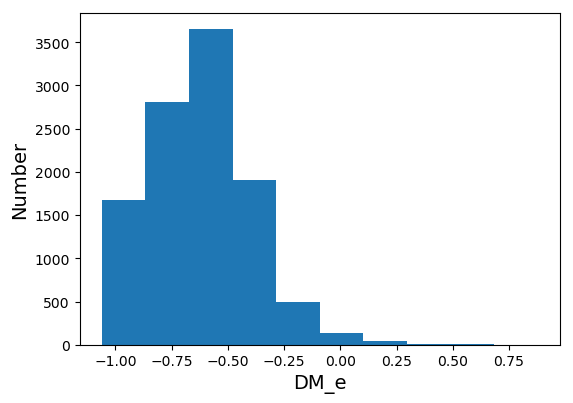

In [7]:
fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

Var = dDM_2
np.min(Var), np.median(Var), np.max(Var)

ax.hist(np.log10(Var))

ax.set_xlabel('DM_e', fontsize=14)
ax.set_ylabel('Number', fontsize=14)

In [8]:
def lineF(x, a, b):
    return a*x+b


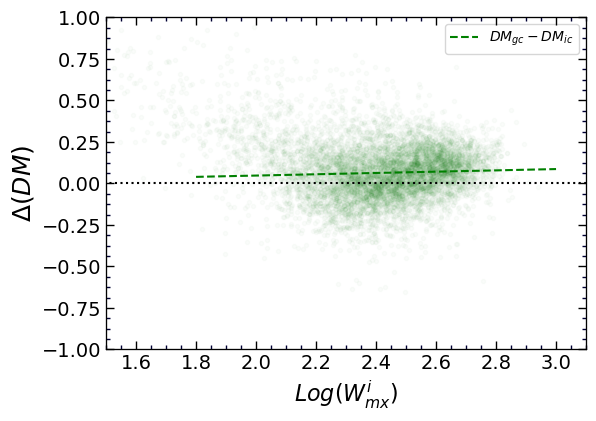

In [9]:
x = np.linspace(1.8,3, 20)

fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((ggg>0) & (iii>0) & (SSqlt>=3))
dDM = DM_g-DM_i
ax.plot(logWimx[indx], dDM[indx], 'g.', alpha=0.02)
P = np.where(logWimx[indx]>2)
fit, cov = curve_fit(lineF, logWimx[indx][P], dDM[indx][P])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='g', label=r'$DM_{gc}-DM_{ic}$')
    

# indx, = np.where((rrr>0) & (iii>0) & (SSqlt>=3))
# dDM = DM_r-DM_i
# ax.plot(logWimx[indx], dDM[indx], 'r.', alpha=0.02)
# P = np.where(logWimx[indx]>2)
# fit, cov = curve_fit(lineF, logWimx[indx][P], dDM[indx][P])
# a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='r', label=r'$DM_{rc}-DM_{ic}$')

# indx, = np.where((zzz>0) & (iii>0) & (SSqlt>=3))
# dDM = DM_z-DM_i
# ax.plot(logWimx[indx], dDM[indx], '.', alpha=0.02, color='maroon')
# P = np.where(logWimx[indx]>2)
# fit, cov = curve_fit(lineF, logWimx[indx][P], dDM[indx][P])
# a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='maroon', label=r'$DM_{zc}-DM_{ic}$')




set_axes(ax, (1.5,3.1), (-1,1), fontsize=14)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16) 
ax.set_ylabel(r'$\Delta (DM)$', fontsize=18) 

ax.legend()

ax.plot([-10,10], [0,0], 'k:')

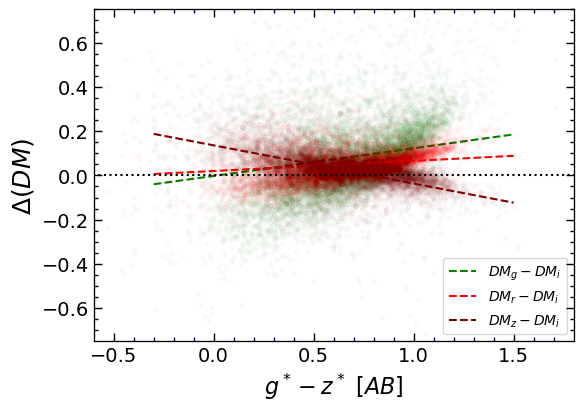

In [10]:
x = np.linspace(-0.3,1.5, 20)

fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 


indx, = np.where((ggg>0) & (iii>0) & (SSqlt>=3))
dDM = DM_g-DM_i
ax.plot(g_z[indx], dDM[indx], 'g.', alpha=0.02)
fit, cov = curve_fit(lineF, g_z[indx], dDM[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='g', label=r'$DM_{g}-DM_{i}$')

indx, = np.where((rrr>0) & (iii>0) & (SSqlt>=3))
dDM = DM_r-DM_i
ax.plot(g_z[indx], dDM[indx], 'r.', alpha=0.02)
fit, cov = curve_fit(lineF, g_z[indx], dDM[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='r', label=r'$DM_{r}-DM_{i}$')

indx, = np.where((zzz>0) & (iii>0) & (SSqlt>=3))
dDM = DM_z-DM_i
ax.plot(g_z[indx], dDM[indx], '.', alpha=0.02, color='maroon')
fit, cov = curve_fit(lineF, g_z[indx], dDM[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='maroon', label=r'$DM_{z}-DM_{i}$')

# indx, = np.where((zzz>0) & (iii>0) & (SSqlt>=3))
# dDM = 0.5*(DM_z+DM_r)-DM_i
# ax.plot(g_z[indx], dDM[indx], '.', alpha=0.02, color='b')


set_axes(ax, (-0.6,1.8), (-0.75,0.75), fontsize=14)

ax.set_xlabel(r'$g^*-z^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$\Delta (DM)$', fontsize=18) 
ax.legend()

ax.plot([-10,10], [0,0], 'k:')

[ 0.02826924 -0.07918633]
0.019460619388058976


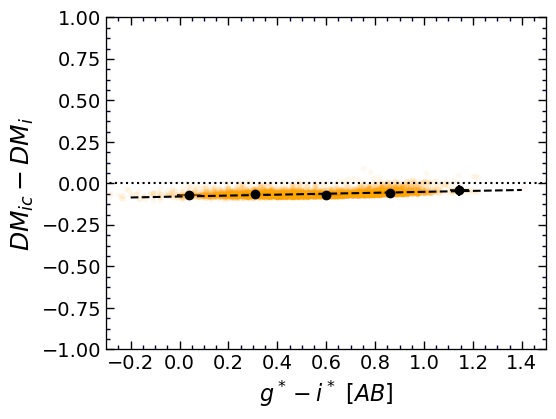

In [11]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where( (iii>0)  & (SSqlt>=3))
dDM =  DM_ic - DM_gc
dDM_e = np.sqrt(dDM_ic**2+dDM_gc**2)
ax.plot(g_i[indx], dDM[indx], '.', alpha=0.05, color='orange')

x = np.linspace(-0.2,1.4, 20)
fit, cov = curve_fit(lineF, g_i[indx], dDM[indx], sigma=dDM_e[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='k')
print fit 
set_axes(ax, (-0.3,1.5), (-1,1), fontsize=14)

ax.set_xlabel(r'$g^*-i^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$DM_{ic} - DM_{i}$', fontsize=18) 
# ax.legend()




X = g_i[indx]
Y = dDM[indx]
###############################
for i in np.arange(-0.1,1.1,0.3):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################

               
# v = np.linspace(-0.2,1.4,200)
# c = np.polyfit(X,Y, 1)
# plt.plot(v,c[0]*v+c[1], 'k--')

###############################

ax.plot([-10,10], [0,0], 'k:')

dDM_mod = DM_ic - DM_gc - (a*g_i+b)
print np.std(dDM)

(2176,)


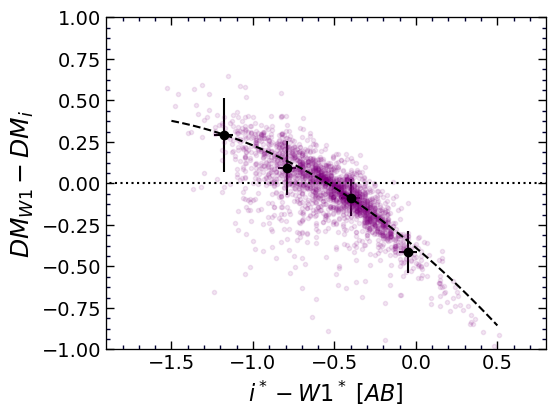

In [12]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0)  & (WWqlt>=3)  & (SSqlt>=3))
print indx.shape
dDM =  DM_1 - DM_i
dDM_e = np.sqrt(dDM_1**2+dDM_i**2)
ax.plot(i_w1[indx], dDM[indx], '.', alpha=0.1, color='purple')

x = np.linspace(-1.7,0.7, 20)
fit, cov = curve_fit(lineF, i_w1[indx], dDM[indx], sigma=dDM_e[indx])
a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='k')

set_axes(ax, (-1.9,0.8), (-1,1), fontsize=14)

ax.set_xlabel(r'$i^*-W1^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$DM_{W1} - DM_{i}$', fontsize=18) 
# ax.legend()




X = i_w1[indx]
Y = dDM[indx]
Ye = dDM_e[indx]
###############################
for i in np.arange(-1.3,0.1,0.4):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################

               
v = np.linspace(-1.5,0.5,200)
c = np.polyfit(X,Y, 2, w=1./Ye)
plt.plot(v,c[0]*v**2+c[1]*v+c[2], 'k--')

###############################

ax.plot([-10,10], [0,0], 'k:')

[-0.22588673  0.52227085  2.49497079  5.0085534 ]


<ErrorbarContainer object of 3 artists>

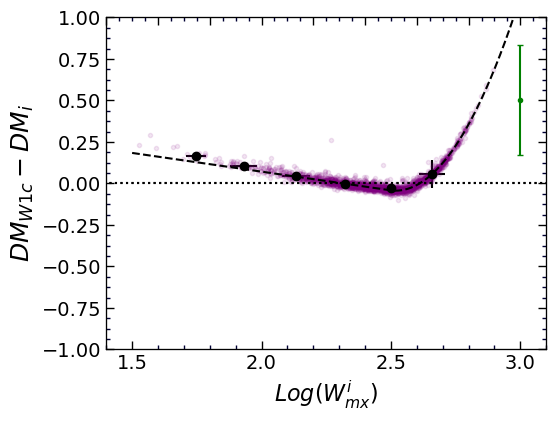

In [13]:
####################################
def esnQuadratic(logW, slope, zp, logW0, A):


    X0 = logW0 
    X = logW
    B = -2.*A*X0
    M = slope*X+zp
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0) & (WWqlt>=3)  & (SSqlt>=3))
dDM =   DM_1c - DM_i
dDM_e = np.sqrt(dDM_1c**2+dDM_1mu**2)
ax.plot(logWimx[indx], dDM[indx], '.', alpha=0.1, color='purple')


x = np.linspace(1.5,3, 500)
ix, = np.where((logWimx[indx]>1.5) & (logWimx[indx]<2.50)) 
fit, cov = curve_fit(lineF, logWimx[indx][ix], dDM[indx][ix], sigma=dDM_e[indx][ix])
a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='purple')




fit, cov = curve_fit(esnQuadratic, logWimx[indx], dDM[indx], sigma=dDM_e[indx])
slope=fit[0]; zp=fit[1]; logW0=fit[2]; A=fit[3]
print fit
ax.plot(x, esnQuadratic(x, slope, zp, logW0, A), '--', color='k')



set_axes(ax, (1.4, 3.1), (-1,1), fontsize=14)


ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16) 
ax.set_ylabel(r'$DM_{W1c} - DM_{i}$', fontsize=18) 

ax.plot([-10,10], [0,0], 'k:')
ax.set_xticks(np.arange(1.5,3.5, step=0.5))


ax.plot([-10,10], [0,0], 'k:')


X = logWimx[indx]
Y = dDM[indx]
Ye = dDM_e[indx]
###############################
for i in np.arange(1.6,2.8,0.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################
        
        
v = np.linspace(1.5,3,200)
c = np.polyfit(X,Y, 2)
# plt.plot(v,c[0]*v**2+c[1]*v+c[2], 'k--')

###############################

# print  c

# fit, cov = np.polyfit(X,Y, 2, cov=True, w=1./Ye)
# print fit
# print [np.sqrt(cov[i][i]) for i in [0,1,2]]


ax.errorbar([3], [0.5], yerr=np.median(dDM_e), fmt='.', color='green', capsize=2)

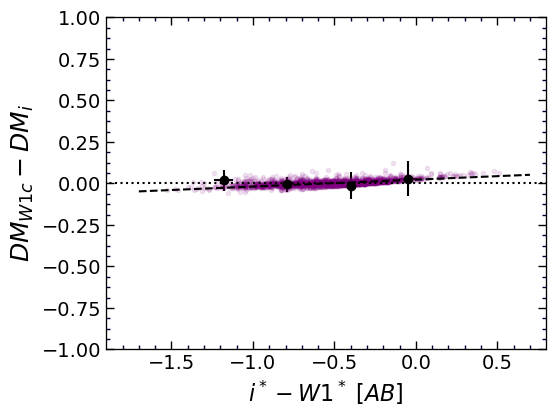

In [14]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0)  & (WWqlt>=3)  & (SSqlt>=3))
dDM =  DM_1c - DM_i
dDM_e = np.sqrt(dDM_1c**2+dDM_i**2)

dDM_mod = dDM - esnQuadratic(logWimx, slope, zp, logW0, A)

ax.plot(i_w1[indx], dDM_mod[indx], '.', alpha=0.1, color='purple')

x = np.linspace(-1.7,0.7, 20)
fit, cov = curve_fit(lineF, i_w1[indx], dDM_mod[indx], sigma=dDM_e[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='k')

set_axes(ax, (-1.9,0.8), (-1,1), fontsize=14)

ax.set_xlabel(r'$i^*-W1^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$DM_{W1c} - DM_{i}$', fontsize=18) 
# ax.legend()




X = i_w1[indx]
Y = dDM[indx]
###############################
for i in np.arange(-1.3,0.1,0.4):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################
ax.plot([-10,10], [0,0], 'k:')

0.014295866857613143


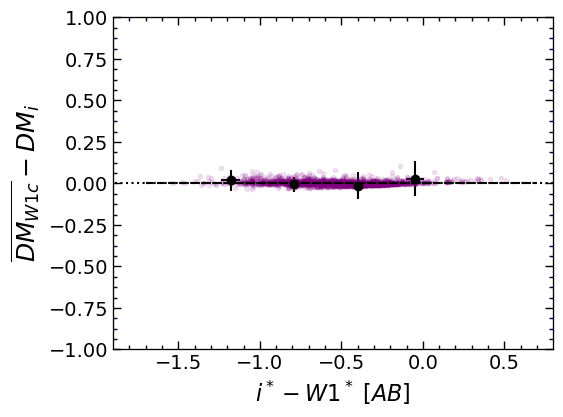

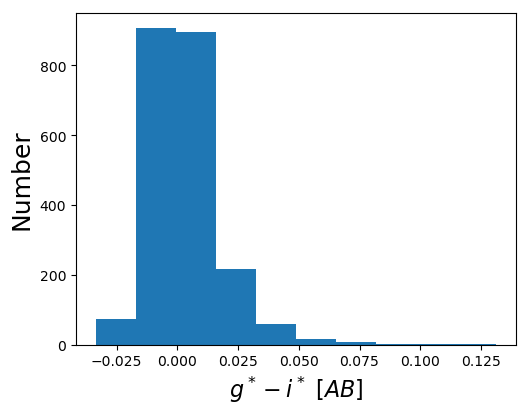

In [15]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0)  & (WWqlt>=3)  & (SSqlt>=3))
dDM =  DM_1c - DM_i 
dDM_e = np.sqrt(dDM_1c**2+dDM_i**2)

dDM_mod = dDM - esnQuadratic(logWimx, slope, zp, logW0, A) - (a*i_w1+b)

ax.plot(i_w1[indx], dDM_mod[indx], '.', alpha=0.1, color='purple')

x = np.linspace(-1.7,0.7, 20)
fit, cov = curve_fit(lineF, i_w1[indx], dDM_mod[indx], sigma=dDM_e[indx])
ax.plot(x, fit[0]*x+fit[1], '--', color='k')

set_axes(ax, (-1.9,0.8), (-1,1), fontsize=14)

ax.set_xlabel(r'$i^*-W1^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$\overline{DM_{W1c}} - DM_{i}$', fontsize=18) 
# ax.legend()




X = i_w1[indx]
Y = dDM[indx]
###############################
for i in np.arange(-1.3,0.1,0.4):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################
ax.plot([-10,10], [0,0], 'k:')


fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax0 = fig.add_subplot(111) 
ax0.hist(dDM_mod[indx])
ax0.set_xlabel(r'$g^*-i^* \/\/ [AB]$', fontsize=16) 
ax0.set_ylabel('Number', fontsize=18) 
print np.std(dDM_mod[indx])

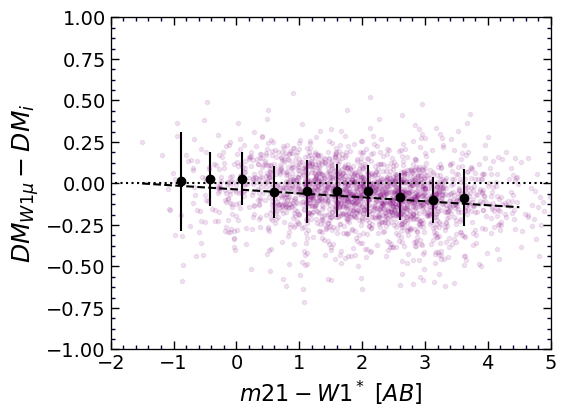

In [16]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0)  & (WWqlt>=3)  & (SSqlt>=3))
dDM =  DM_1mu - DM_i
dDM_e = np.sqrt(dDM_1mu**2+dDM_i**2)
ax.plot(m21_w1[indx], dDM[indx], '.', alpha=0.1, color='purple')

x = np.linspace(-1.5,4.5, 20)
fit, cov = curve_fit(lineF, m21_w1[indx], dDM[indx], sigma=dDM_e[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='k')

set_axes(ax, (-2,5), (-1,1), fontsize=14)

ax.set_xlabel(r'$m21-W1^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$DM_{W1 \mu} - DM_{i}$', fontsize=18) 
# ax.legend()




X = m21_w1[indx]
Y = dDM[indx]
###############################
for i in np.arange(-1.,4,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################
ax.plot([-10,10], [0,0], 'k:')

-0.38698403615121213 -0.29363583771868873


<ErrorbarContainer object of 3 artists>

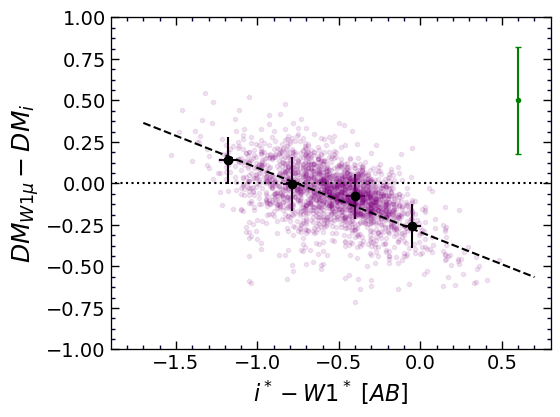

In [17]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0)  & (WWqlt>=3)  & (SSqlt>=3))
dDM =  DM_1mu - DM_i
dDM_e = np.sqrt(dDM_1mu**2+dDM_1mu**2)

# ax.errorbar(i_w1[indx], dDM[indx], yerr=dDM_e[indx], fmt='.', alpha=0.1, color='purple')
ax.plot(i_w1[indx], dDM[indx], '.', alpha=0.1, color='purple')

x = np.linspace(-1.7,0.7, 20)
fit, cov = curve_fit(lineF, i_w1[indx], dDM[indx], sigma=dDM_e[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='k')
print a, b

# fit, cov = curve_fit(lineF, i_w1[indx], dDM[indx])
# a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='r')

set_axes(ax, (-1.9,0.8), (-1,1), fontsize=14)

ax.set_xlabel(r'$i^*-W1^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$DM_{W1 \mu} - DM_{i}$', fontsize=18) 
# ax.legend()


X = i_w1[indx]
Y = dDM[indx]
###############################
for i in np.arange(-1.3,0.1,0.4):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################
ax.plot([-10,10], [0,0], 'k:')


ax.errorbar([0.6], [0.5], yerr=np.median(dDM_e), fmt='.', color='green', capsize=2)

In [18]:
ZPcalibs = makeZP(table, band='w1')
ZPcalibs['pgc']

array([  218,   701,  1014,  2758,  2789,  3238,  5818,  5896,  6574,
        6595,  6699,  7671,  9031,  9332,  9962, 11139, 12460, 13163,
       13179, 13602, 13727, 17819, 18536, 21102, 21396, 22277, 23110,
       24930, 26512, 26761, 28120, 28357, 28630, 29128, 30197, 30819,
       31671, 32192, 32207, 34554, 34695, 37466, 38148, 38688, 39346,
       39422, 39423, 39461, 39600, 40692, 41020, 41066, 41618, 41812,
       41823, 42002, 42038, 42081, 42407, 42408, 42637, 42741, 43451,
       44182, 44536, 44982, 45084, 45279, 45849, 46127, 46153, 47368,
       47847, 48334, 49448, 50073, 53641, 54392, 54470, 60921, 62836,
       65603, 67045, 67908, 68535, 69327, 71220, 72228, 73049])

[-0.13230863  0.42175439 -0.30687598]
[ 0.10851569 -0.7933485   1.21054762]
[0.09021389447462562, 0.43776297119783264, 0.52955189860091]


<ErrorbarContainer object of 3 artists>

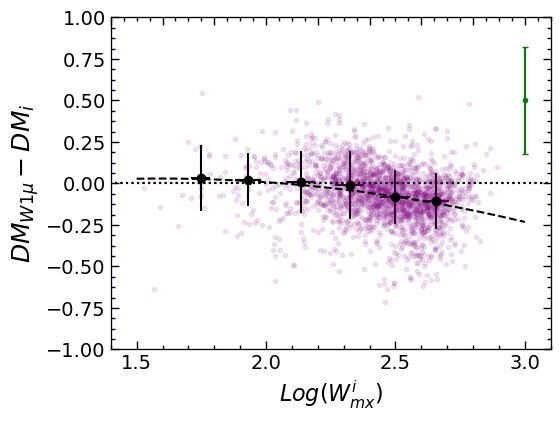

In [19]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0) & (WWqlt>=3)  & (SSqlt>=3))
dDM =   DM_1mu - DM_i
dDM_e = np.sqrt(dDM_1mu**2+dDM_1mu**2)
ax.plot(logWimx[indx], dDM[indx], '.', alpha=0.1, color='purple')


# x = np.linspace(-5,5, 20)
# ix, = np.where((logWimx[indx]>2.2) & (logWimx[indx]<2.75)) 
# fit, cov = curve_fit(lineF, logWimx[indx][ix], dDM[indx][ix])
# a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='purple')

set_axes(ax, (1.4, 3.1), (-1,1), fontsize=14)


ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16) 
ax.set_ylabel(r'$DM_{W1 \mu} - DM_{i}$', fontsize=18) 

ax.plot([-10,10], [0,0], 'k:')
ax.set_xticks(np.arange(1.5,3.5, step=0.5))


ax.plot([-10,10], [0,0], 'k:')


X = logWimx[indx]
Y = dDM[indx]
Ye = dDM_e[indx]
###############################
for i in np.arange(1.6,2.8,0.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='k', alpha=1.0, ms=6)     

        
###############################
        
        
v = np.linspace(1.5,3,200)
c = np.polyfit(X,Y, 2)
plt.plot(v,c[0]*v**2+c[1]*v+c[2], 'k--')

###############################

print  c

fit, cov = np.polyfit(X,Y, 2, cov=True, w=1./Ye)
print fit
print [np.sqrt(cov[i][i]) for i in [0,1,2]]


ax.errorbar([3], [0.5], yerr=np.median(dDM_e), fmt='.', color='green', capsize=2)

In [20]:
def rrmmss(delta):
    

    
    Y_fit2 = delta
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N))
    
    return rms

[ZP] Should be zero:  0.0 0.13432413670065382 0.0
(-0.015436323319996245, 0.03340819068998776)
[Gals] Should be zero:  -0.09825165158844629 0.1471878565195259


<ErrorbarContainer object of 3 artists>

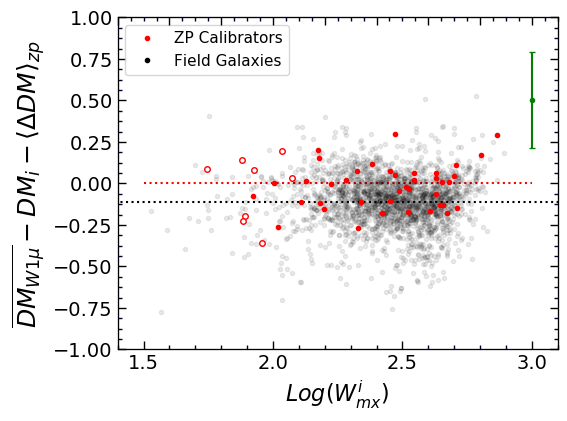

In [21]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 


set_axes(ax, (1.4, 3.1), (-1,1), fontsize=14)


ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16) 
ax.set_ylabel(r'$\overline{DM_{W1 \mu}}-DM_{i}-\langle \Delta DM \rangle_{zp}$', fontsize=18) 


ax.plot([1.5,3], [0,0], 'r:')
zp_med =  0.10996465819456636
ax.plot([-10,10], [-zp_med, -zp_med], 'k:')

dDM_mod   = dDM[indx]-(c[0]*logWimx[indx]**2+c[1]*logWimx[indx]+c[2])-zp_med
dDM_mod_e = np.sqrt(dDM_e[indx]**2+((2.*c[0]*logWimx[indx]+c[1])*logWimx_e[indx])**2)

ax.plot(logWimx[indx], dDM_mod , '.', alpha=0.08, color='k')

x_zp = []
y_zp = []
ye_zp = []
for i, idd in enumerate(pgc_tab):
    y_mod = dDM[i] - (c[0]*logWimx[i]**2+c[1]*logWimx[i]+c[2])-zp_med
    y_mod_e = np.sqrt(dDM_e[i]**2+((2.*c[0]*logWimx[i]+c[1])*logWimx_e[i])**2)
    if idd in ZPcalibs['pgc'] and not idd in [44536,68535,5896,48334, 40809]:
        if idd in calib_maglim :
            ax.plot(logWimx[i], y_mod, 'ro', ms=4, mfc='white')
        else:
            x_zp.append(logWimx[i])
            y_zp.append(y_mod)
            ye_zp.append(y_mod_e)
x_zp = np.asarray(x_zp)
y_zp = np.asarray(y_zp)
ye_zp = np.asarray(ye_zp)
ax.plot(x_zp, y_zp, 'r.', label='ZP Calibrators')
# ax.errorbar(x_zp, y_zp, yerr=ye_zp, fmt='.', color='g')

def esn_mean(y, e):
    n = len(y)
    m = np.sum(y/e)/np.sum(1./e)
    sigma = np.sqrt(1./(np.sum(1./e**2)))
    
    return m, sigma


ix, = np.where(np.abs(y_zp<0.5))
zp_med = np.median(y_zp[ix])
zp_std = np.std(y_zp[ix])
print '[ZP] Should be zero: ', zp_med, rrmmss(y_zp[ix]-zp_med), zp_med/np.sqrt(len(y_zp[ix]))
print esn_mean(y_zp[ix], ye_zp[ix])



ix, = np.where(np.abs(dDM_mod<1))
gals_med = np.median(dDM_mod[ix])
gals_std = np.std(dDM_mod[ix])
print '[Gals] Should be zero: ', gals_med, rrmmss(dDM_mod[ix]-gals_med)

ax.set_xticks(np.arange(1.5,3.5, step=0.5))
ax.plot([-100],[2], 'k.', label='Field Galaxies')           
ax.legend(fontsize=11)


ax.errorbar([3], [0.5], yerr=np.median(dDM_mod_e), fmt='.', color='green', capsize=2)

-0.3003432876465688 -0.16902685060939104


<ErrorbarContainer object of 3 artists>

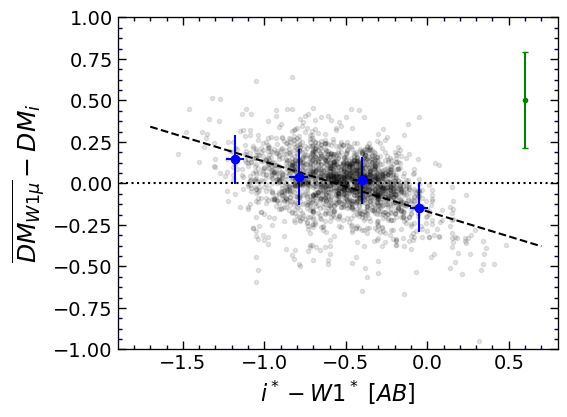

In [22]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0)  & (WWqlt>=3)  & (SSqlt>=3))
dDM =  DM_1mu - DM_i
dDM_e = np.sqrt(dDM_1mu**2+dDM_1mu**2)


Ymod =  dDM[indx]-(c[0]*logWimx[indx]**2+c[1]*logWimx[indx]+c[2])

DM_1mu_mod = DM_1mu - (c[0]*logWimx**2+c[1]*logWimx+c[2])

Ymod_e = np.sqrt(dDM_e[indx]**2+((2.*c[0]*logWimx[indx]+c[1])*logWimx_e[indx])**2)

ax.plot(i_w1[indx], Ymod, '.', alpha=0.1, color='k')

x = np.linspace(-1.7,0.7, 20)
fit, cov = curve_fit(lineF, i_w1[indx], Ymod, sigma=Ymod_e)
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='k')
print a,b 

set_axes(ax, (-1.9,0.8), (-1,1), fontsize=14)

ax.set_xlabel(r'$i^*-W1^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$\overline{DM_{W1 \mu}} - DM_{i}$', fontsize=18) 
# ax.legend()

ax.plot([-10,10], [0,0], 'k:')



X = i_w1[indx]
Y = Ymod
###############################
for i in np.arange(-1.3,0.1,0.4):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='b', alpha=1.0, ms=6)     

        
###############################

ax.errorbar([0.6], [0.5], yerr=np.median(Ymod_e), fmt='.', color='green', capsize=2)

In [23]:
indx, = np.where((WWqlt>=2)  & (SSqlt==0))
len(indx)

3206

In [24]:
indx, = np.where((WWqlt>=2)  & (SSqlt>=2))
len(indx)

2217

In [25]:
indx, = np.where((WWqlt==0)  & (SSqlt>=2))
len(indx)

5244

In [26]:
indx, = np.where((ggg>0) & (rrr>0)  & (SSqlt>=3))
plt.plot(g_r[indx], 0.5*(GCR[indx]+RCR[indx]), '.', alpha=0.05, color='g')


plt.xlim(-0.3,1.0)
plt.ylim(-1, 1)

print np.std((GCR[indx]+RCR[indx])/2.)

print np.std((GCR[indx]-RCR[indx]))

NameError: name 'GCR' is not defined

In [27]:
def adjustDM(DMo, dDMo, DM_i, dDM_i, COLindex, xlim=(-2,2), ylim=(-0.9,0.9), 
             quad=False, indx=None, xlabel='', ylabel=''):
    
    
    fig = py.figure(figsize=(12, 4), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    from matplotlib.ticker import MultipleLocator
    ax1.yaxis.set_major_locator(MultipleLocator(0.5))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax2.yaxis.set_major_locator(MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
    _, y_ax =  set_axes(ax1, xlim, ylim, fontsize=14)
    y_ax.yaxis.set_major_locator(MultipleLocator(0.5))
    y_ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    _, y_ax =  set_axes(ax2, xlim, ylim, fontsize=14)
    y_ax.yaxis.set_major_locator(MultipleLocator(0.5))
    y_ax.yaxis.set_minor_locator(MultipleLocator(0.1))    
    dDM =  DMo - DM_i 
    dDM_e = np.sqrt(dDMo**2+dDM_i**2)
    
    v = np.linspace(xlim[0]+0.1, xlim[1]-0.1,200)
        
    if indx is None:
        indx = np.arange(len(dDM))
    
    ax1.plot(COLindex[indx], dDM[indx], '.', alpha=0.05, color='k')    
    
    if not quad:
        fit, cov = curve_fit(lineF, COLindex[indx], dDM[indx], sigma=dDM_e[indx])
        correction = (fit[0]*COLindex+fit[1])
        ax1.plot(v,fit[0]*v+fit[1], 'r--')
    else:
        fit, cov = np.polyfit(COLindex[indx], dDM[indx], 2, cov=True, w=1./dDM_e[indx])
        correction = (fit[0]*COLindex**2+fit[1]*COLindex+fit[2])
        ax1.plot(v,fit[0]*v**2+fit[1]*v+fit[2], 'r--')
    
    print "Fit params:"
    for i in range(len(fit)):
        print '%.3f'%fit[i]+'\pm'+'%.3f'%np.sqrt(cov[i][i])
    
    dDM_mod = dDM - correction
    ax2.plot(COLindex[indx], dDM_mod[indx], '.', alpha=0.05)
    

    ##############################
    X = COLindex[indx]
    Y = dDM_mod[indx]
    Y0 = dDM[indx]
    Ye = dDM_e[indx]
    for i in np.arange(xlim[0]+0.1, xlim[1]-0.1,0.2):
        xp = []
        yp = []
        yp0 = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+0.2:
                xp.append(xi)
                yp.append(Y[ii])
                yp0.append(Y0[ii])
        if len(xp)>0:
            ax2.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6)     
            ax1.errorbar(np.median(xp), np.median(yp0), yerr=np.std(yp0), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6)   
    ###############################    
    ax1.plot([-10,10], [0,0], 'k:')
    ax2.plot([-10,10], [0,0], 'k:')
    ###############################
    c = np.polyfit(X,Y, 2, w=1./Ye)
#     ax2.plot(v,c[0]*v**2+c[1]*v+c[2], 'k--')
    ###############################
    
    Ylm = ax2.get_ylim() ; Xlm = ax2.get_xlim()
    x0 = 0.9*Xlm[0]+0.1*Xlm[1]
    y0 = 0.9*Ylm[0]+0.10*Ylm[1]
    RMS = np.std(Y)
    ax2.text(x0,y0, r"$RMS$" +": %.2f [mag]" % RMS, fontsize=16, color='k')    
    
    x0 = 0.13*Xlm[0]+0.87*Xlm[1]
    ax2.errorbar(x0, [-0.5], yerr=np.median(dDM_e),xerr=0.05*1.414, fmt='.', color='green', capsize=3)
    
    ax1.set_xlabel(xlabel, fontsize=18) 
    ax1.set_ylabel(r'$'+ylabel+'- DM_{i}$', fontsize=18) 
    ax2.set_xlabel(xlabel, fontsize=18) 
    ax2.set_ylabel(r'$\overline{'+ylabel+'} - DM_{i}$', fontsize=18) 
    

    
    plt.subplots_adjust(hspace=.0, wspace=0.25)
    
    return [ax1,ax2], DMo-correction, fit, cov
    
###############################    ###############################



Fit params:
1.026\pm0.012
-0.598\pm0.007


(7423,)

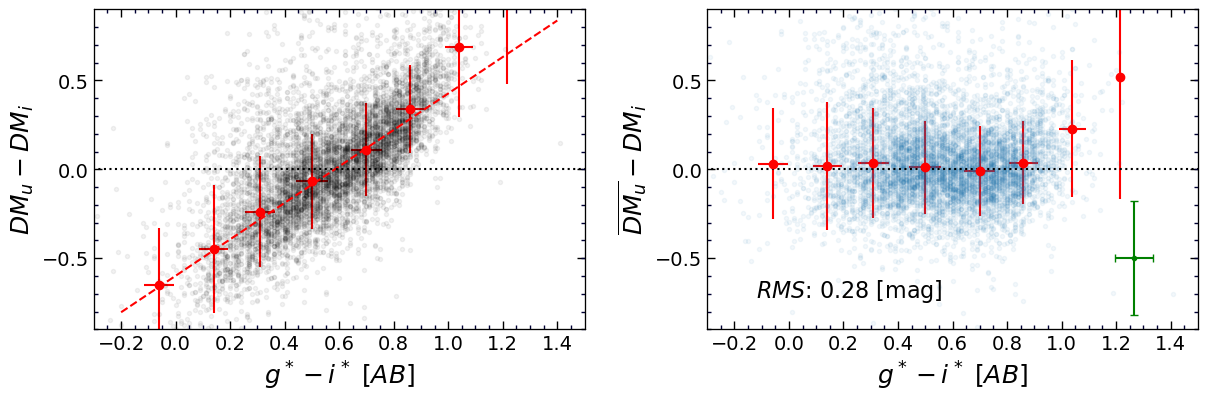

In [28]:
indx, = np.where((uuu>0) & (ggg>0) & (iii>0) & (SSqlt>=3))
axes, DM_ui_gi, fit, cov = adjustDM(DM_u, dDM_u, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{u}'
                        )

indx.shape

Fit params:
0.192\pm0.003
-0.064\pm0.002


(7423,)

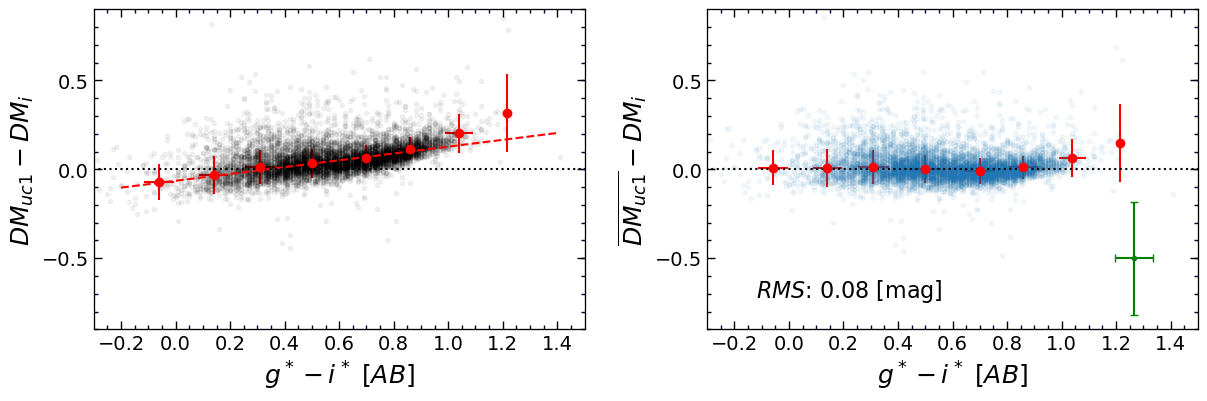

In [29]:
indx, = np.where((uuu>0) & (ggg>0) & (iii>0) & (SSqlt>=3))
axes, DM_uui_gi, fit, cov = adjustDM(DM_uc, dDM_uc, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{uc1}'
                        )

indx.shape

Fit params:
0.483\pm0.006
-0.223\pm0.004
Fit params:
0.121\pm0.002
0.004\pm0.001


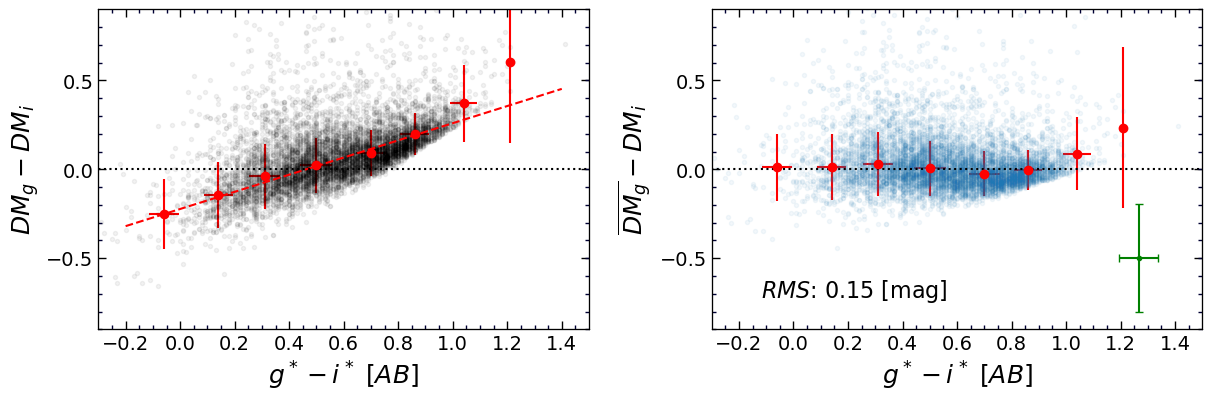

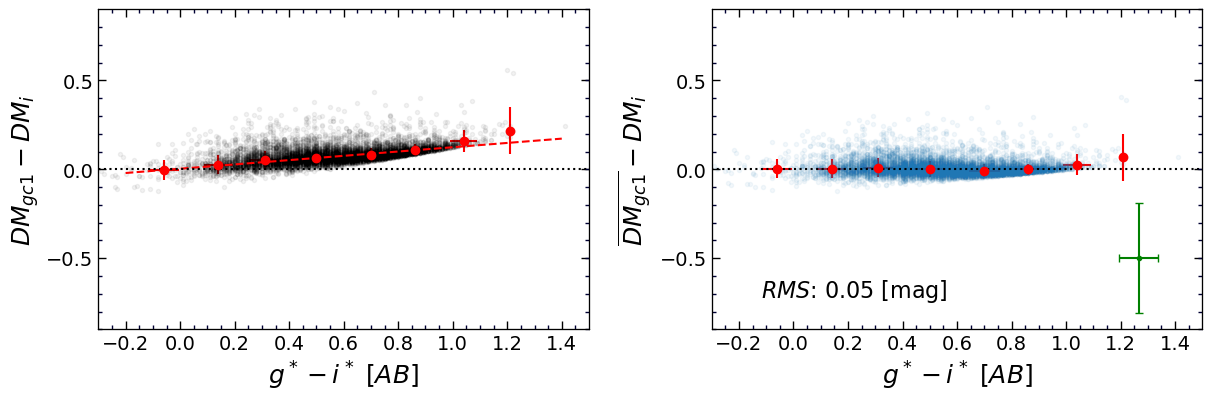

In [30]:
indx, = np.where((ggg>0) & (iii>0) & (SSqlt>=3))
axes, DM_g_gi, fit, cov = adjustDM(DM_g, dDM_g, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{g}'
                        )

indx, = np.where((ggg>0) & (iii>0) & (SSqlt>=3))
axes, DM_ggi_gi, fit, cov = adjustDM(DM_gc, dDM_gc, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{gc1}'
                        )

# indx, = np.where((ggg>0) & (zzz>0) & (SSqlt>=3))
# axes, DM_ggz_gz, fit, cov = adjustDM(DM_gcz, dDM_gcz, DM_i, dDM_i, g_z, 
#                         xlim=(-0.4,1.6), indx=indx, quad=True,
#                         xlabel=r'$g^*-z^* \/\/ [AB]$', 
#                         ylabel='DM_{gcz}'
#                         )

# indx, = np.where((ggg>0) & (rrr>0) & (SSqlt>=3))
# axes, DM_ggr_gr, fit, cov = adjustDM(DM_gcr, dDM_gcr, DM_i, dDM_i, g_r, 
#                         xlim=(-0.1,0.8), indx=indx, quad=False,
#                         xlabel=r'$g^*-r^* \/\/ [AB]$', 
#                         ylabel='DM_{gcr}'
#                         )

Fit params:
0.204\pm0.003
-0.075\pm0.002
Fit params:
0.062\pm0.002
0.028\pm0.001
Fit params:
0.261\pm0.005
-0.127\pm0.003


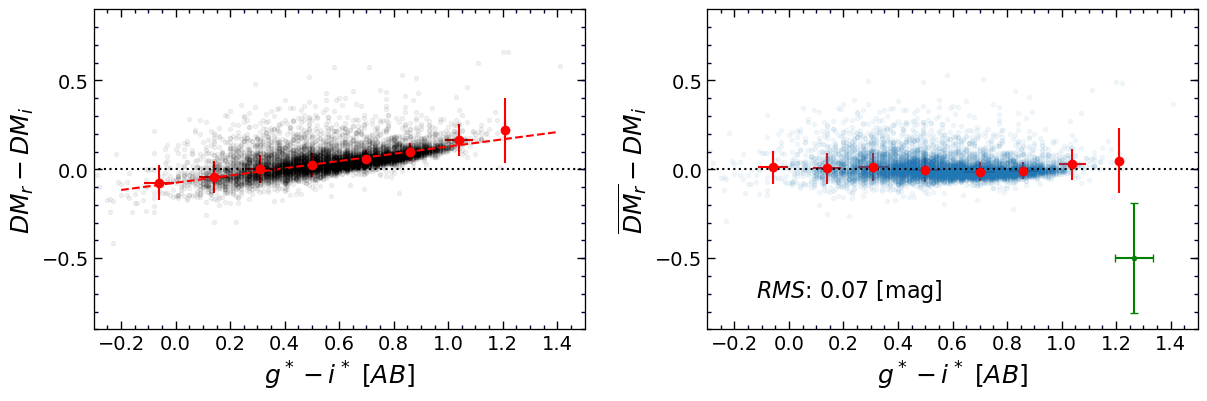

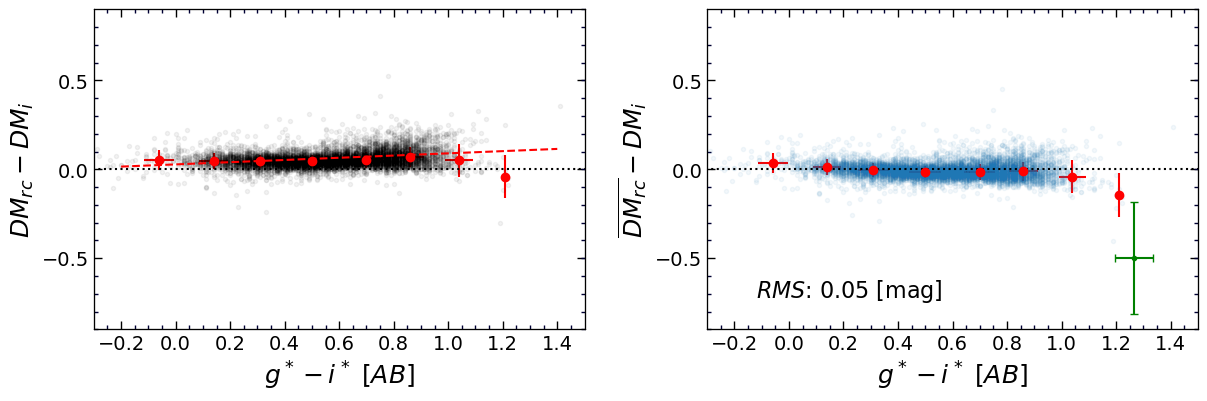

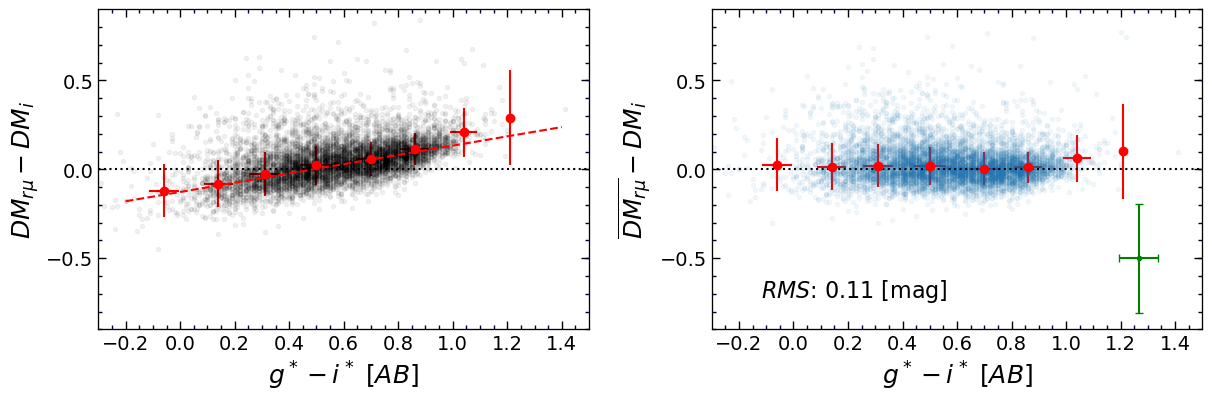

In [31]:
indx, = np.where((ggg>0) & (rrr>0)  & (iii>0) & (SSqlt>=3))
axes, DM_r_gi, fit, cov = adjustDM(DM_r, dDM_r, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{r}'
                        )

indx, = np.where((ggg>0) & (rrr>0)  & (iii>0) & (SSqlt>=3))
axes, DM_rgi_gi, fit, cov = adjustDM(DM_rc, dDM_rc, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{rc}'
                        )

# indx, = np.where((ggg>0) & (iii>0) & (rrr>0) & (zzz>0) & (SSqlt>=3))
# axes, DM_rgi_rz, fit, cov = adjustDM(DM_rc, dDM_rc, DM_i, dDM_i, r_z, 
#                         xlim=(-0.3,0.8), indx=indx, quad=True,
#                         xlabel=r'$r^*-z^* \/\/ [AB]$', 
#                         ylabel='DM_{rc}'
#                         )

# indx, = np.where((ggg>0) & (iii>0) & (zzz>0) & (SSqlt>=3))
# axes, DM_rgz_gz, fit, cov = adjustDM(DM_rcz, dDM_rcz, DM_i, dDM_i, g_z, 
#                         xlim=(-0.4,1.6), indx=indx, quad=True,
#                         xlabel=r'$g^*-z^* \/\/ [AB]$', 
#                         ylabel='DM_{rcz}'
#                         )

# indx, = np.where((ggg>0) & (rrr>0) & (SSqlt>=3))
# axes, DM_rgr_gr, fit, cov = adjustDM(DM_rcr, dDM_rcr, DM_i, dDM_i, g_r, 
#                         xlim=(-0.1,0.8), indx=indx, quad=False,
#                         xlabel=r'$g^*-r^* \/\/ [AB]$', 
#                         ylabel='DM_{rcr}'
#                         )

indx, = np.where((ggg>0) & (rrr>0)  & (iii>0) & (SSqlt>=3))
axes, DM_rmu_gi, fit, cov = adjustDM(DM_rmu, dDM_rmu, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{r\mu}'
                        )

Fit params:
-0.058\pm0.005
0.057\pm0.003
Fit params:
0.094\pm0.006
-0.035\pm0.003


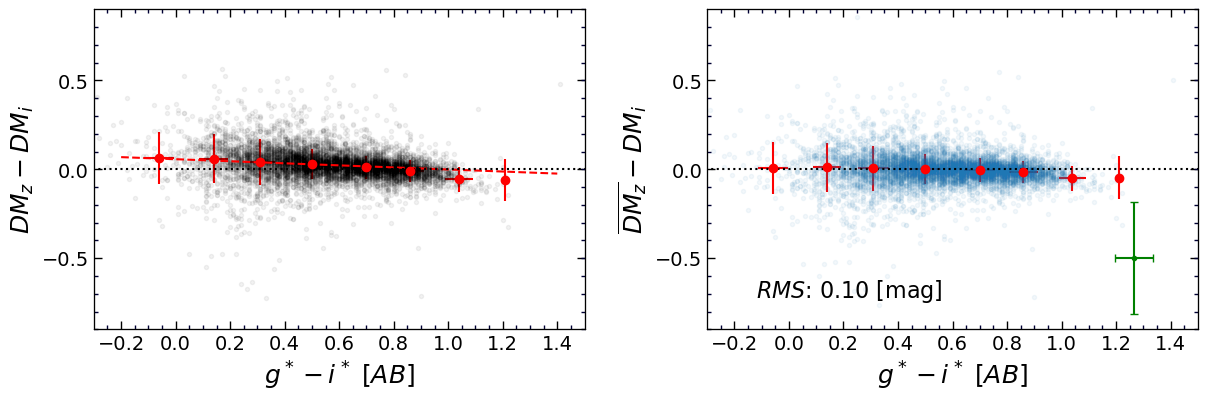

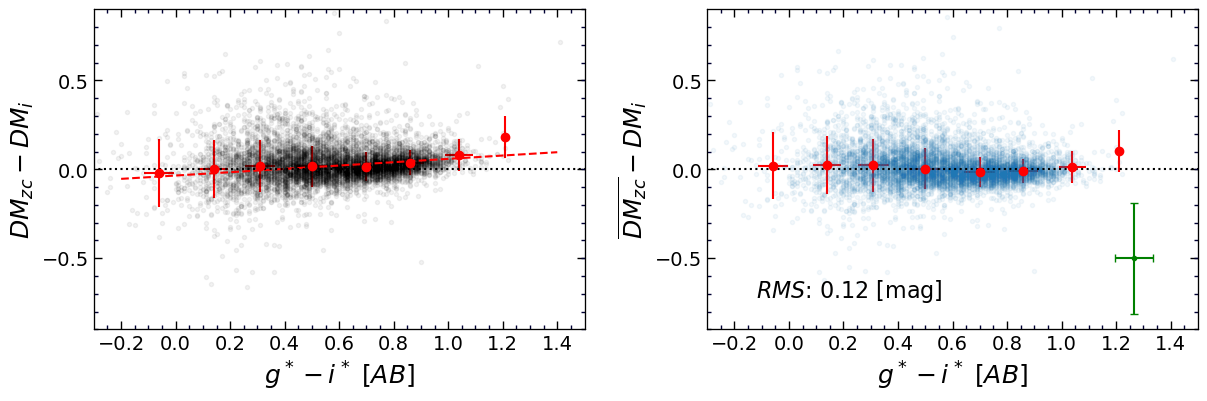

In [32]:
indx, = np.where((ggg>0) & (iii>0)  & (zzz>0) & (SSqlt>=3))
axes, DM_z_gi, fit, cov = adjustDM(DM_z, dDM_z, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{z}'
                        )


indx, = np.where((ggg>0) & (iii>0)  & (zzz>0) & (SSqlt>=3))
axes, DM_zc_gi, fit, cov = adjustDM(DM_zc, dDM_zc, DM_i, dDM_i, g_i, 
                        xlim=(-0.3,1.5), indx=indx, quad=False,
                        xlabel=r'$g^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{zc}'
                        )

# indx, = np.where((rrr>0)  & (zzz>0) & (SSqlt>=3))
# axes, DM_z_rz, fit, cov = adjustDM(DM_z, dDM_z, DM_i, dDM_i, r_z, 
#                         xlim=(-0.3,0.8), indx=indx, quad=False,
#                         xlabel=r'$r^*-z^* \/\/ [AB]$', 
#                         ylabel='DM_{z}'
#                         )

# indx, = np.where((ggg>0) & (zzz>0) & (SSqlt>=3))
# axes, DM_z_gz, fit, cov = adjustDM(DM_z, dDM_z, DM_i, dDM_i, g_z, 
#                         xlim=(-0.4,1.6), indx=indx, quad=True,
#                         xlabel=r'$g^*-z^* \/\/ [AB]$', 
#                         ylabel='DM_{z}'
#                         )

# indx, = np.where((iii>0) & (zzz>0) & (SSqlt>=3))
# axes, DM_z_iz, fit, cov = adjustDM(DM_z, dDM_z, DM_i, dDM_i, i_z, 
#                         xlim=(-0.3,0.4), indx=indx, quad=True,
#                         xlabel=r'$i^*-z^* \/\/ [AB]$', 
#                         ylabel='DM_{z}'
#                         )




Fit params:
0.013\pm0.037
-0.167\pm0.027
0.083\pm0.005
Fit params:
-0.355\pm0.009
-0.006\pm0.010
0.044\pm0.002


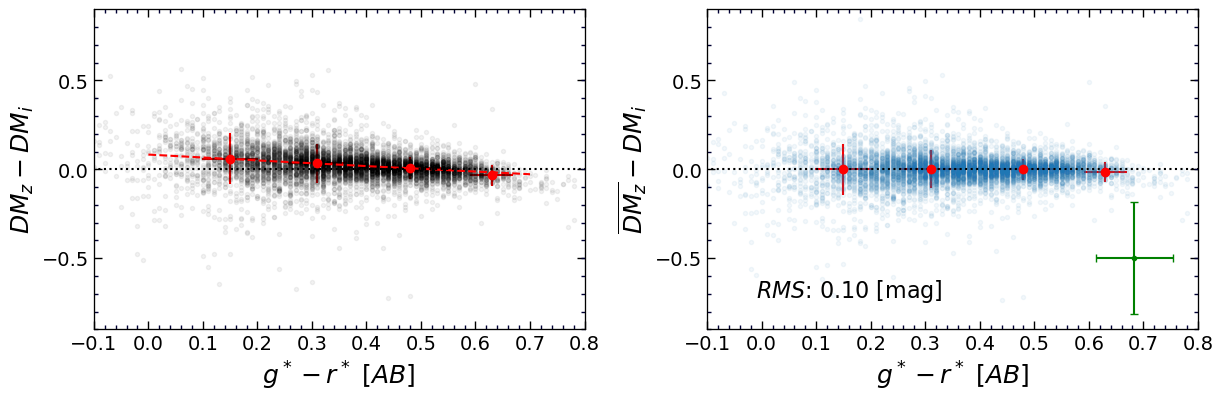

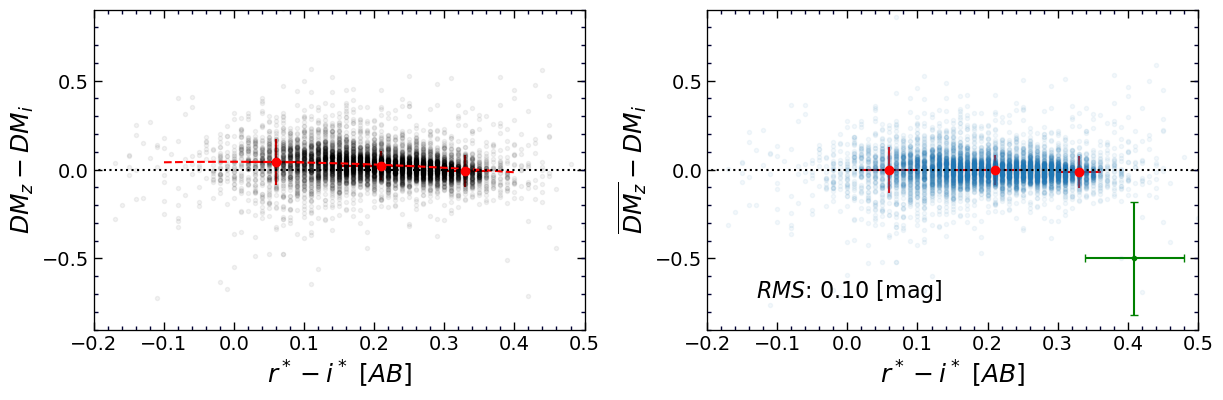

In [33]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (SSqlt>=3))
axes, DM_z_gr, fit, cov = adjustDM(DM_z, dDM_z, DM_i, dDM_i, g_r, 
                        xlim=(-0.1,0.8), indx=indx, quad=True,
                        xlabel=r'$g^*-r^* \/\/ [AB]$', 
                        ylabel='DM_{z}'
                        )


indx, = np.where((rrr>0) & (iii>0) & (zzz>0) & (SSqlt>=3))
axes, DM_z_ri, fit, cov = adjustDM(DM_z, dDM_z, DM_i, dDM_i, r_i, 
                        xlim=(-0.2,0.5), indx=indx, quad=True,
                        xlabel=r'$r^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{z}'
                        )

In [34]:
len(DM_z_ri)
len(pgc)

NameError: name 'pgc' is not defined

0.001 0.782
107


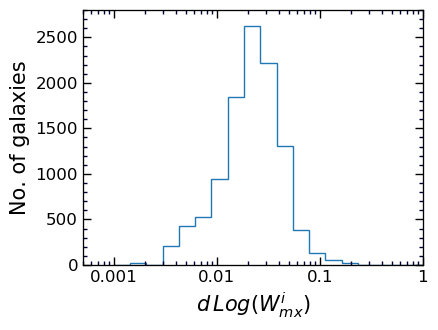

In [35]:
fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

ax.hist(logWimx_e, histtype='step', bins=np.logspace(np.log10(0.001),np.log10(1.0), 20))
print np.min(logWimx_e), np.max(logWimx_e)
# plt.xlim(0,0.3)

print len(np.where(logWimx_e>0.1)[0])


ax.set_xlabel(r'$d\/ Log( W_{mx}^i)$', fontsize=15)
ax.set_ylabel('No. of galaxies', fontsize=15)

ax.set_xscale('log')
plt.xticks([0.001,0.01,0.1,1], ('0.001','0.01','0.1','1'))


from matplotlib.ticker import NullFormatter

x_ax, y_ax = set_axes(ax, [0.0005,1], [0,2800], fontsize=12)

x_ax.set_xscale('log')
x_ax.xaxis.set_major_formatter(NullFormatter())  
x_ax.xaxis.set_minor_formatter(NullFormatter())


/home/ehsan/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0.5,0,'$Log( W_{mx}^i)$')

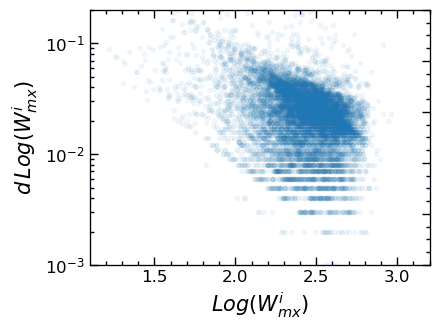

In [36]:
fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

ax.set_yscale('log')

x_ax, y_ax = set_axes(ax, [1.1, 3.2], [0,1], fontsize=12)

ax.plot(logWimx, logWimx_e, '.', alpha=0.05)
ax.set_ylim(0,0.2)

ax.set_ylabel(r'$d\/ Log( W_{mx}^i)$', fontsize=15)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=15)

In [37]:
len(pgc_tab)
len(dDM_i)

10736

In [38]:
cf3  = np.genfromtxt('cf3.csv' , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
pgc_cf3 = cf3['PGC']
DM_cf3  = cf3['DM']
eDM_cf3 = cf3['eDM']
N_cf3   = cf3['N']  
C_cf3   = cf3['C']  
F_cf3   = cf3['F']
I_cf3   = cf3['I']
S_cf3   = cf3['S']

In [39]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def biasFuc(logW, a,b, c):
    x = (logW-c)
#     return a*(1+np.tanh(x*b))
    return a*sigmoid(x*b)

a, b, c =  0.16388796, 12.93848418,  2.52223501

bias = biasFuc(logWimx, a, b, c)

NameError: name 'DM_z_iz' is not defined

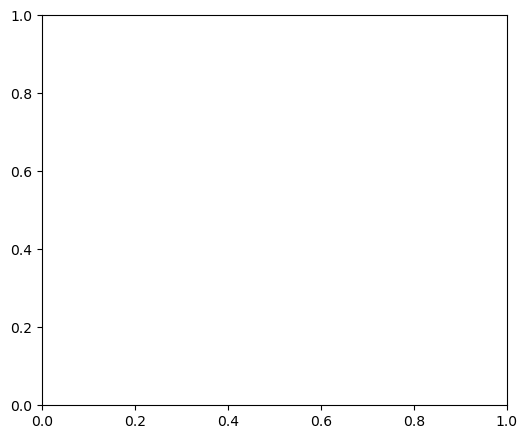

In [40]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


esn_DM = (DM_i+DM_z_iz+DM_ggi_gi+DM_rgr_gr)/4. + bias

tmp = []
for i, id in enumerate(pgc_cf3):
    
    if id in pgc_tab:
        ix, = np.where(pgc_tab==id)
        if (ggg[ix][0]>0) & (rrr[ix][0]>0) & (iii[ix][0]>0) & (zzz[ix][0]>0) & (SSqlt[ix][0]>=3):
            
            sig = np.sqrt(dDM_i[ix][0]**2+eDM_cf3[i]**2)*0
            
            if N_cf3[i]=='N':
                ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], yerr=sig, capsize=3, color='k', fmt='.' )
                
            
            if C_cf3[i]=='C':
                ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], xerr=eDM_cf3[i], yerr=sig, capsize=3, color='r', fmt='.' )
                tmp.append(esn_DM[ix][0]- DM_cf3[i])                
            
            if F_cf3[i]=='F':
                ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], xerr=eDM_cf3[i], yerr=sig, capsize=3, color='b', fmt='.' )
                
#             if I_cf3[i]=='I':
#                 ax.errorbar(DM_cf3[i], esn_DM[ix][0]- DM_cf3[i], xerr=eDM_cf3[i]*0, yerr=sig, capsize=0, color='g', fmt='.' )
                
            if S_cf3[i]=='S':
                ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], xerr=eDM_cf3[i], yerr=sig, capsize=3, color='purple', fmt='.' )
                                                
            
ax.plot([26,37],[0,0], 'k:')


med = np.mean(tmp)
ax.plot([26,37],[med, med], 'r-',lw=2)
print med


In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


# esn_DM = (DM_i+DM_z_iz+DM_ggi_gi+DM_rgr_gr)/4. + bias
esn_DM = (DM_ic) + bias

tmp = []
for i, id in enumerate(pgc_cf3):
    
    if id in pgc_tab:
        ix, = np.where(pgc_tab==id)
        if (ggg[ix][0]>0) & (rrr[ix][0]>0) & (iii[ix][0]>0) & (zzz[ix][0]>0) & (SSqlt[ix][0]>=3):
            
               ax.errorbar(Vhel[ix][0], DM_i[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
                
            

                                                
            
ax.plot([0,17500],[0,0], 'r:')

ax.set_ylim(-3,3)


In [ ]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5

gc = SkyCoord(l=0, b=0, unit='deg', frame='galactic')
sc = SkyCoord(ra=0.0009600*15, dec=23.0876400, unit='deg', frame=FK5, equinox='J2000.0')

sc.transform_to(gc)  

In [55]:
len(DM_rc)

10736

In [71]:
for i in range(15):
    row = ''
    row += str(pgc_tab[i]) + ' & '
    
#     row += '%.2f'%DM_u[i] + '$\pm$' + '%.2f'%dDM_u[i]  + ' & '
#     row += '%.2f'%DM_ui_gi[i] + ' & '
    
#     row += '%.2f'%DM_uc[i] + '$\pm$' + '%.2f'%dDM_uc[i]  + ' & '
#     row += '%.2f'%DM_uui_gi[i] + ' & '
    
    
    
    if Sqlt[i] > 0:
    
        row += '%.2f'%DM_g[i] + '$\pm$' + '%.2f'%dDM_g[i]  + ' & '
        row += '%.2f'%DM_g_gi[i] + ' & '

        row += '%.2f'%DM_gc[i] + '$\pm$' + '%.2f'%dDM_gc[i]  + ' & '
        row += '%.2f'%DM_ggi_gi[i] + ' & '

        row += '%.2f'%DM_r[i] + '$\pm$' + '%.2f'%dDM_r[i]  + ' & '
        row += '%.2f'%DM_r_gi[i] + ' & '    

        row += '%.2f'%DM_rc[i] + '$\pm$' + '%.2f'%dDM_rc[i]  + ' & '
        row += '%.2f'%DM_rgi_gi[i] + ' & '

        row += '%.2f'%DM_i[i] + '$\pm$' + '%.2f'%dDM_i[i]  + ' & '
        
        row += '%.2f'%DM_z[i] + '$\pm$' + '%.2f'%dDM_z[i]  + ' & '
        row += '%.2f'%DM_z_gi[i] + ' & '    

        row += '%.2f'%DM_zc[i] + '$\pm$' + '%.2f'%dDM_zc[i]  + ' & '
        row += '%.2f'%DM_zc_gi[i] + ' & '
        
    else:
        row +=  ' & '
        row +=  ' & '

        row +=  ' & '
        row +=  ' & '

        row += ' & '
        row += ' & '    

        row += ' & '
        row += ' & '

        row += ' & '
                
        row += ' & '
        row += ' & '    

        row += ' & '
        row += ' & '    
    
    if Wqlt[i] > 0:    
    
        

        row += '%.2f'%DM_1[i] + '$\pm$' + '%.2f'%dDM_1[i]  + ' & '

        row += '%.2f'%DM_1mu[i] + '$\pm$' + '%.2f'%dDM_1mu[i]  + ' & '
        row += '%.2f'%DM_1mu_mod[i] + ' \\\\ '
        
    else:


        row +=  ' & '

        row +=  ' & '
        row +=  ' \\\\ '        
    
    print row


2 &  &  &  &  &  &  &  &  &  &  &  &  &  & 34.11$\pm$0.29 & 34.11$\pm$0.28 & 34.26 \\ 
4 & 33.56$\pm$0.15 & 33.55 & 33.49$\pm$0.15 & 33.43 & 33.50$\pm$0.15 & 33.48 & 33.45$\pm$0.15 & 33.39 & 33.37$\pm$0.15 & 33.41$\pm$0.15 & 33.38 & 33.47$\pm$0.15 & 33.47 & 33.48$\pm$0.14 & 33.31$\pm$0.14 & 33.32 \\ 
12 &  &  &  &  &  &  &  &  &  &  &  &  &  & 34.79$\pm$0.22 & 34.70$\pm$0.21 & 34.81 \\ 
16 & 34.73$\pm$0.22 & 34.58 & 34.65$\pm$0.23 & 34.55 & 34.63$\pm$0.23 & 34.54 & 34.58$\pm$0.24 & 34.51 & 34.54$\pm$0.24 & 34.50$\pm$0.24 & 34.48 & 34.53$\pm$0.24 & 34.49 & 34.44$\pm$0.25 & 34.50$\pm$0.24 & 34.58 \\ 
55 & 34.02$\pm$0.22 & 34.09 & 34.11$\pm$0.23 & 34.07 & 34.06$\pm$0.23 & 34.07 & 34.11$\pm$0.24 & 34.06 & 34.06$\pm$0.24 & 34.11$\pm$0.24 & 34.07 & 34.08$\pm$0.24 & 34.09 & 34.29$\pm$0.25 & 34.15$\pm$0.25 & 34.18 \\ 
68 & 34.38$\pm$0.34 & 34.40 & 34.49$\pm$0.36 & 34.43 & 34.38$\pm$0.36 & 34.38 & 34.44$\pm$0.38 & 34.39 & 34.44$\pm$0.38 & 34.38$\pm$0.38 & 34.35 & 34.33$\pm$0.38 & 34.33 & 34.35$